In [6]:
import torch
import torch.nn as nn
import torch.functional as F
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from collections import Counter


import re
import os

## Importing the CPP data from kaggle

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
!git clone https://github.com/ggml-org/llama.cpp.git

fatal: destination path 'llama.cpp' already exists and is not an empty directory.


In [9]:
import os

# Check that the repo exists in your current working directory
os.listdir("llama.cpp")[:10]

['.clang-format',
 '.clang-tidy',
 '.devops',
 '.dockerignore',
 '.ecrc',
 '.editorconfig',
 '.flake8',
 '.git',
 '.github',
 '.gitignore']

In [10]:
import glob

# Find all .cpp files inside the cloned repo (recursively)
cpp_files = glob.glob("llama.cpp/**/*.cpp", recursive=True)

print(f"Found {len(cpp_files)} .cpp files")
print("Example files:\n", cpp_files[:10])

Found 287 .cpp files
Example files:
 ['llama.cpp\\common\\arg.cpp', 'llama.cpp\\common\\chat-parser.cpp', 'llama.cpp\\common\\chat.cpp', 'llama.cpp\\common\\common.cpp', 'llama.cpp\\common\\console.cpp', 'llama.cpp\\common\\json-partial.cpp', 'llama.cpp\\common\\json-schema-to-grammar.cpp', 'llama.cpp\\common\\llguidance.cpp', 'llama.cpp\\common\\log.cpp', 'llama.cpp\\common\\ngram-cache.cpp']


In [5]:
combined_cpp_text = ""

for file in cpp_files:
    try:
        with open(file, "r", encoding="utf-8", errors="ignore") as f:
            combined_cpp_text += f.read() + "\n\n"
    except PermissionError:
        print(f"Skipping (no permission): {file}")
    except Exception as e:
        print(f"Skipping {file} due to error: {e}")

Skipping (no permission): llama.cpp\tools\run\linenoise.cpp


In [11]:
len(combined_cpp_text)

9630781

In [12]:
import re
import pandas as pd
from collections import Counter

# Use your existing in-memory string
cpp_text = combined_cpp_text  # already loaded earlier


tokens = re.findall(r'[A-Za-z_][A-Za-z0-9_]*|[{}()\[\];.,=+\-*/<>!&|^%~?:]', cpp_text)

# Count token frequencies
token_counts = Counter(tokens)
df_counts = pd.DataFrame(token_counts.items(), columns=["token", "frequency"])
df_counts = df_counts.sort_values(by="frequency", ascending=False)

# Show stats
print("Total tokens:", len(tokens))
print("Unique tokens:", len(df_counts))

print("\nTop 20 most frequent tokens:\n")
print(df_counts.head(20).to_string(index=False))

# Optionally save vocabulary to CSV for later reuse
df_counts.to_csv("cpp_vocabulary.csv", index=False)
print("Saved token frequencies to cpp_vocabulary.csv")

Total tokens: 1921171
Unique tokens: 43243

Top 20 most frequent tokens:

token  frequency
    ,     158108
    )     133173
    (     133149
    ;      97125
    =      75513
    .      55306
    -      52459
    {      48510
    }      48324
    /      47706
    :      46015
    *      38322
    >      36900
    [      27829
    ]      27537
    <      22904
const      20527
    +      19941
    &      15324
   if      11989
Saved token frequencies to cpp_vocabulary.csv


In [13]:
import torch

# Create mappings (string ↔ integer)
stoi = {s: i for i, s in enumerate(df_counts["token"])}
itos = {i: s for s, i in stoi.items()}

# Define context size (how many previous tokens to use for prediction)
context_size = 5  # you can experiment with 3–10

# Prepare X (context) and Y (target) lists
X, Y = [], []

for i in range(len(tokens) - context_size):
    context = tokens[i:i + context_size]
    target = tokens[i + context_size]
    X.append([stoi[t] for t in context])
    Y.append(stoi[target])

print(f" Created {len(X):,} training samples")

 Created 1,921,166 training samples


In [14]:
# Move to torch tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: torch.Size([1921166, 5])
Y shape: torch.Size([1921166])


In [15]:
import torch.nn as nn

class NextTokenPredictor(nn.Module):
    def __init__(self, vocab_size, context_size, embed_dim=64, hidden_dim=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(context_size * embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.embed(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = len(stoi)
model = NextTokenPredictor(vocab_size, context_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

batch_size = 1024
epochs = 100

for epoch in range(epochs):
    total_loss = 0.0
    for i in range(0, len(X), batch_size):
        x_batch = X[i:i+batch_size].to(device)
        y_batch = Y[i:i+batch_size].to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

torch.save(model, "cpp_next_token_model2.pt")
print("Model training complete and saved!")

Epoch 1/100, Loss: 8158.2410
Epoch 2/100, Loss: 5987.7782
Epoch 3/100, Loss: 4995.5158
Epoch 4/100, Loss: 4347.9852
Epoch 5/100, Loss: 3900.1983
Epoch 6/100, Loss: 3581.9716
Epoch 7/100, Loss: 3349.8313
Epoch 8/100, Loss: 3166.2782
Epoch 9/100, Loss: 3023.9326
Epoch 10/100, Loss: 2899.5545
Epoch 11/100, Loss: 2790.9057
Epoch 12/100, Loss: 2696.9978
Epoch 13/100, Loss: 2610.9597
Epoch 14/100, Loss: 2535.2656
Epoch 15/100, Loss: 2465.0388
Epoch 16/100, Loss: 2399.4459
Epoch 17/100, Loss: 2340.3272
Epoch 18/100, Loss: 2286.2762
Epoch 19/100, Loss: 2235.7326
Epoch 20/100, Loss: 2187.9197
Epoch 21/100, Loss: 2144.1381
Epoch 22/100, Loss: 2101.4902
Epoch 23/100, Loss: 2062.9437
Epoch 24/100, Loss: 2026.0425
Epoch 25/100, Loss: 1991.7497
Epoch 26/100, Loss: 1958.1768
Epoch 27/100, Loss: 1927.1082
Epoch 28/100, Loss: 1898.3764
Epoch 29/100, Loss: 1871.8807
Epoch 30/100, Loss: 1845.8584
Epoch 31/100, Loss: 1821.3546
Epoch 32/100, Loss: 1798.3707
Epoch 33/100, Loss: 1776.7507
Epoch 34/100, Loss:

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = len(stoi)
model = NextTokenPredictor(vocab_size, context_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

batch_size = 1024
epochs = 300

for epoch in range(epochs):
    total_loss = 0.0
    for i in range(0, len(X), batch_size):
        x_batch = X[i:i+batch_size].to(device)
        y_batch = Y[i:i+batch_size].to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

torch.save(model, "cpp_next_token_model3.pt")
print("✅ Model training complete and saved!")

Epoch 1/300, Loss: 8167.0025
Epoch 2/300, Loss: 5997.9117
Epoch 3/300, Loss: 5019.7336
Epoch 4/300, Loss: 4381.3558
Epoch 5/300, Loss: 3941.0862
Epoch 6/300, Loss: 3623.0453
Epoch 7/300, Loss: 3388.1799
Epoch 8/300, Loss: 3213.0073
Epoch 9/300, Loss: 3066.4927
Epoch 10/300, Loss: 2939.3412
Epoch 11/300, Loss: 2829.9130
Epoch 12/300, Loss: 2734.5950
Epoch 13/300, Loss: 2649.8712
Epoch 14/300, Loss: 2572.6255
Epoch 15/300, Loss: 2501.6202
Epoch 16/300, Loss: 2435.4281
Epoch 17/300, Loss: 2374.3439
Epoch 18/300, Loss: 2316.9997
Epoch 19/300, Loss: 2264.0042
Epoch 20/300, Loss: 2213.5781
Epoch 21/300, Loss: 2165.9317
Epoch 22/300, Loss: 2121.8600
Epoch 23/300, Loss: 2080.6596
Epoch 24/300, Loss: 2042.0376
Epoch 25/300, Loss: 2005.8978
Epoch 26/300, Loss: 1972.5151
Epoch 27/300, Loss: 1939.7732
Epoch 28/300, Loss: 1909.4441
Epoch 29/300, Loss: 1881.8013
Epoch 30/300, Loss: 1854.7480
Epoch 31/300, Loss: 1829.2173
Epoch 32/300, Loss: 1805.8855
Epoch 33/300, Loss: 1783.1133
Epoch 34/300, Loss:

In [16]:
import torch.nn as nn

class NextTokenPredictor(nn.Module):
    def __init__(self, vocab_size, context_size, embed_dim=32, hidden_dim=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(context_size * embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.embed(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = len(stoi)
model = NextTokenPredictor(vocab_size, context_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

batch_size = 1024
epochs = 100

for epoch in range(epochs):
    total_loss = 0.0
    for i in range(0, len(X), batch_size):
        x_batch = X[i:i+batch_size].to(device)
        y_batch = Y[i:i+batch_size].to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

torch.save(model, "cpp_next_token_model4.pt")
print("Model training complete and saved!")

NameError: name 'torch' is not defined

In [17]:
device

device(type='cpu')

In [18]:
import torch
from torch.serialization import safe_globals

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with safe_globals([NextTokenPredictor]):
    model = torch.load("cpp_next_token_model2.pt", map_location=device, weights_only=False)

model.to(device)
model.eval()

NextTokenPredictor(
  (embed): Embedding(43226, 64)
  (fc1): Linear(in_features=320, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=43226, bias=True)
  (activation): ReLU()
)

In [ ]:
import random

def generate_next_tokens(model, seed_tokens, num_tokens=10, temperature=1.0):
    model.eval()
    generated = seed_tokens[:]
    for _ in range(num_tokens):
        context = generated[-context_size:]
        x = torch.tensor([[stoi.get(t, 0) for t in context]], device=device)
        logits = model(x) / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token_id = torch.multinomial(probs[0], num_samples=1).item()
        next_token = itos[next_token_id]
        generated.append(next_token)
    return " ".join(generated)

# Try generating
# Ask user for input text
user_input = input("Enter starting C++ code snippet: ")

# Tokenize the input properly (C++ syntax-aware)
user_tokens = re.findall(r'[A-Za-z_][A-Za-z0-9_]*|[{}()\[\];.,=+\-*/<>!&|^%~?:]', user_input)

# Handle unknown tokens gracefully
user_tokens = [t for t in user_tokens if t in stoi]
if len(user_tokens) < context_size:
    print(f"Input too short, padding with <unk> tokens")
    user_tokens = ['<unk>'] * (context_size - len(user_tokens)) + user_tokens

# Generate new code continuation
generated_code = generate_next_tokens(model, user_tokens, num_tokens=30, temperature=1.0)

print("\nGenerated continuation:\n")
print(generated_code)

⚠️ Input too short, padding with <unk> tokens

Generated continuation:

<unk> int a = ; v5 re , inp_pos it is default common_params_context prealloc_y_last_pipeline_used for x001F78 * x011366 , attention will create bench for a llama_sampler_grammar x02FA0A of NBLKS . * * hex_dump_dspbuf slot .


## Embedding Visualisation

Using device: cpu
✅ Model loaded successfully!
Embedding size: torch.Size([43226, 64])
Embedding matrix shape: (43226, 64)


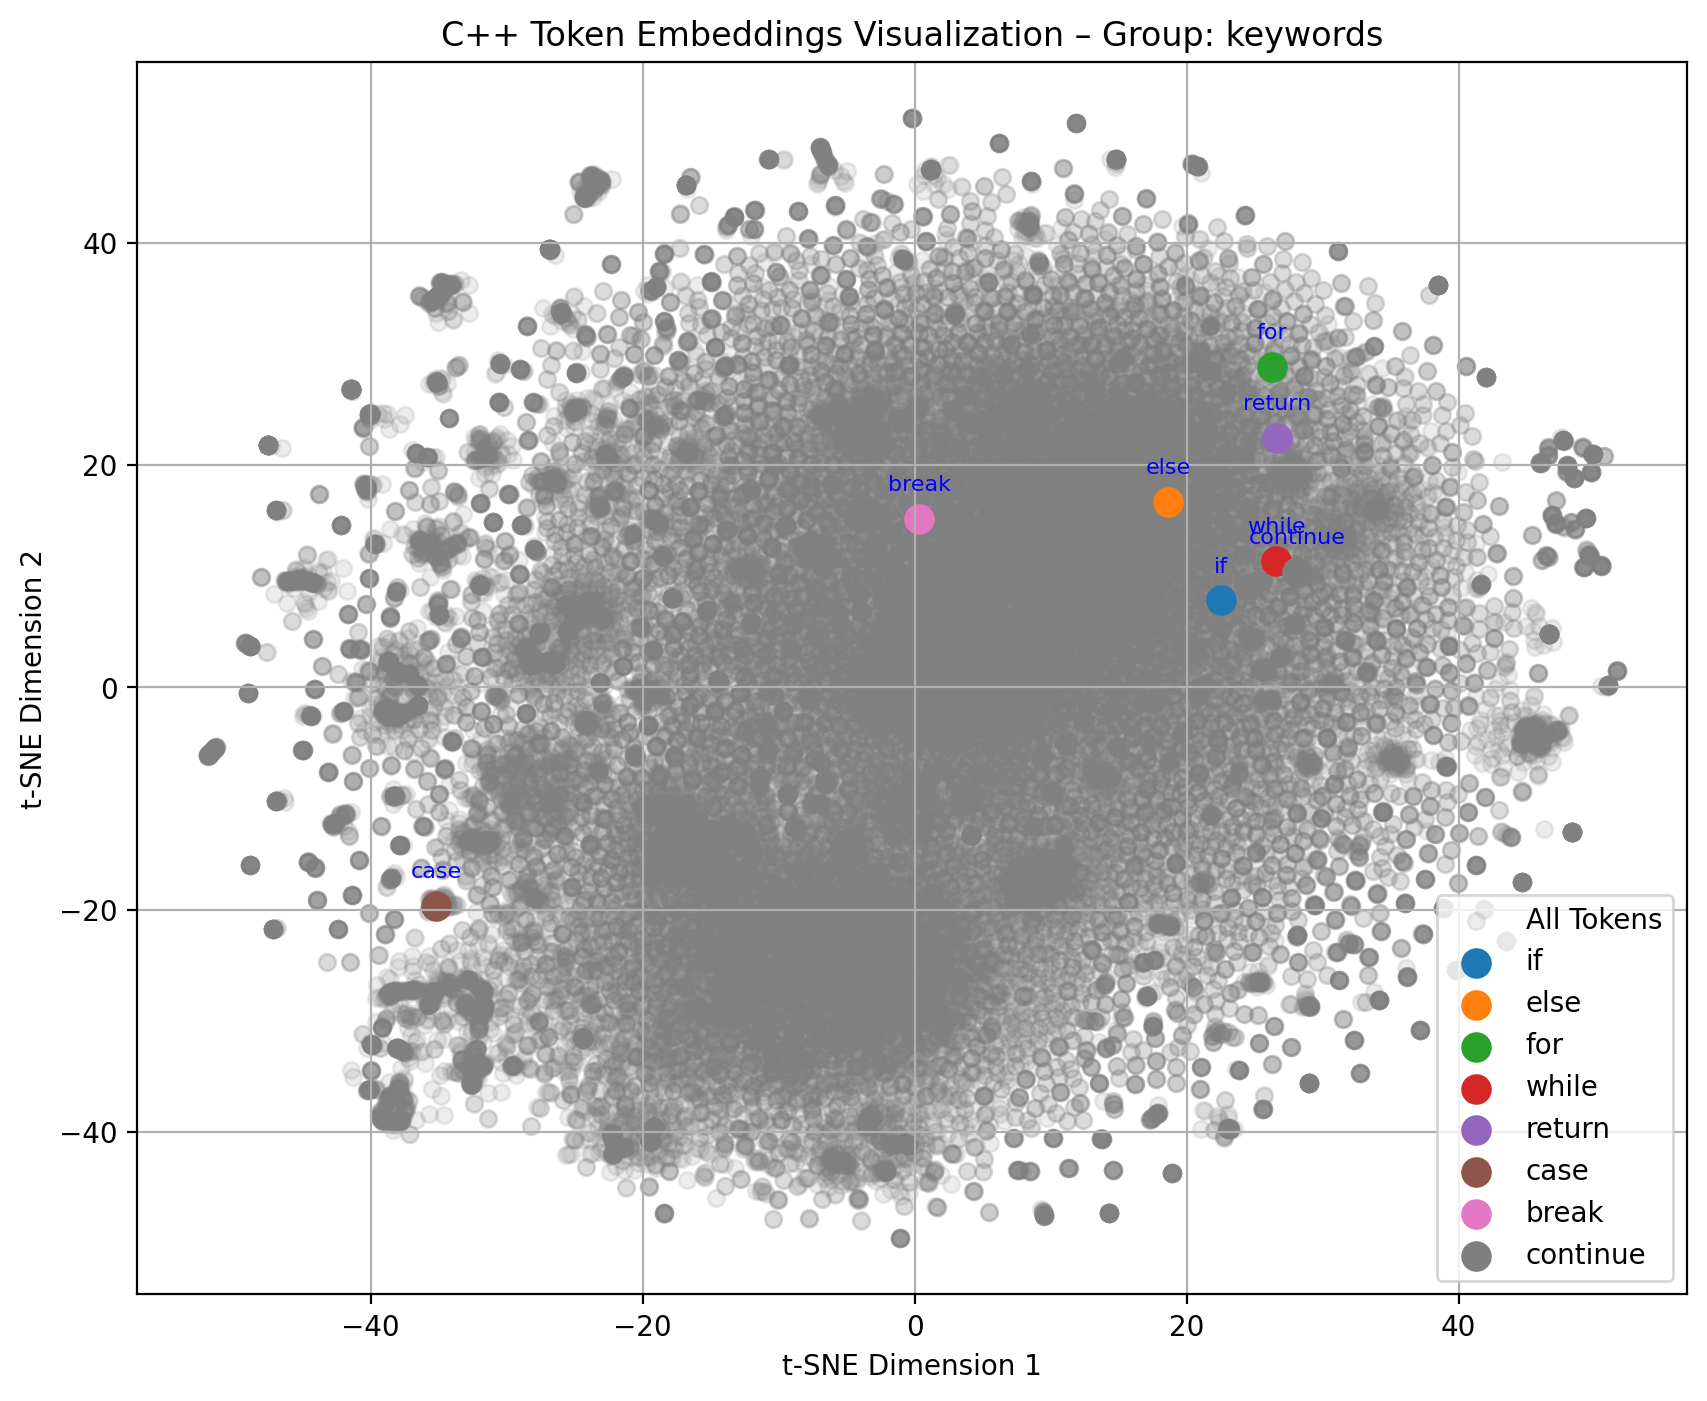

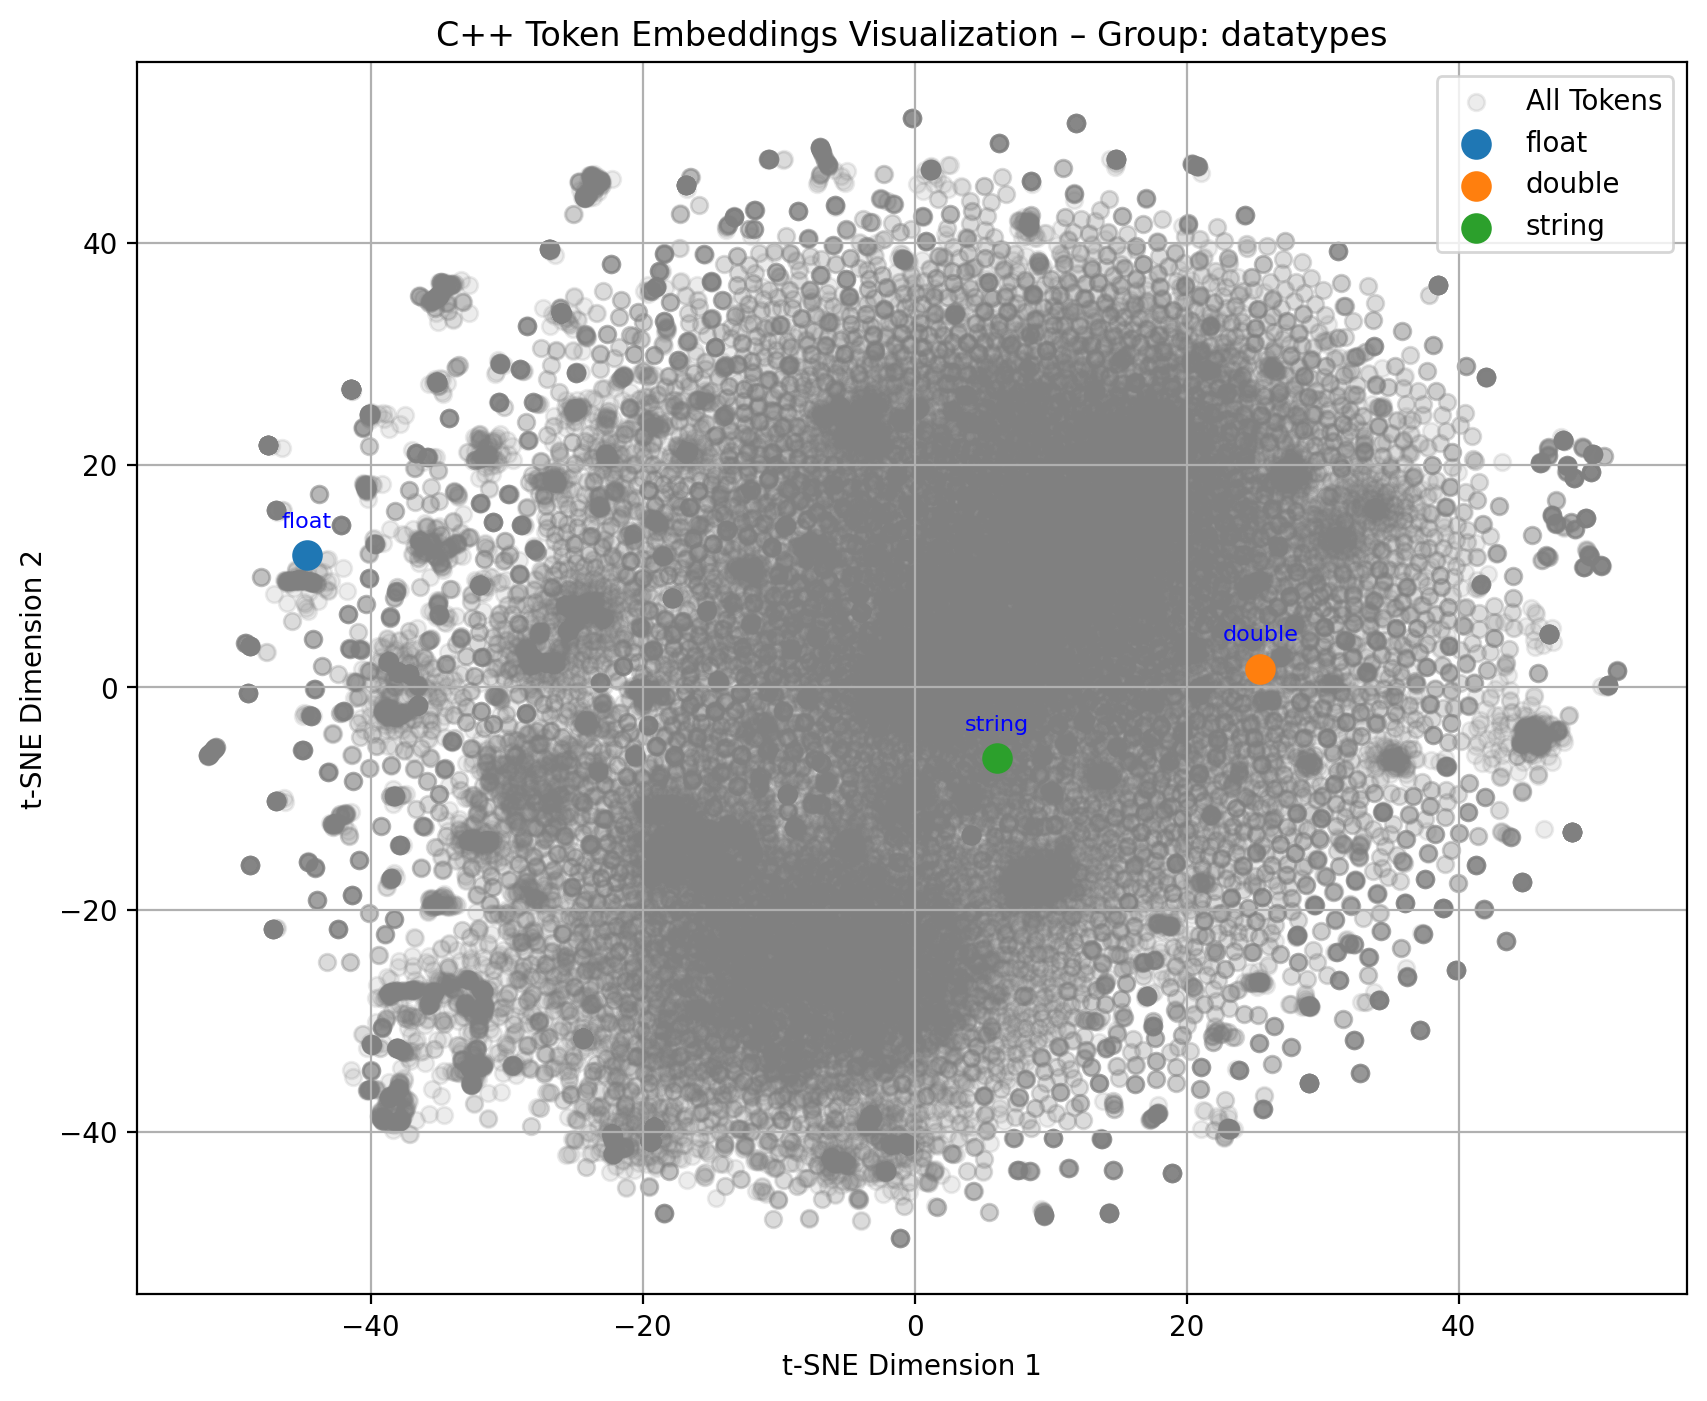

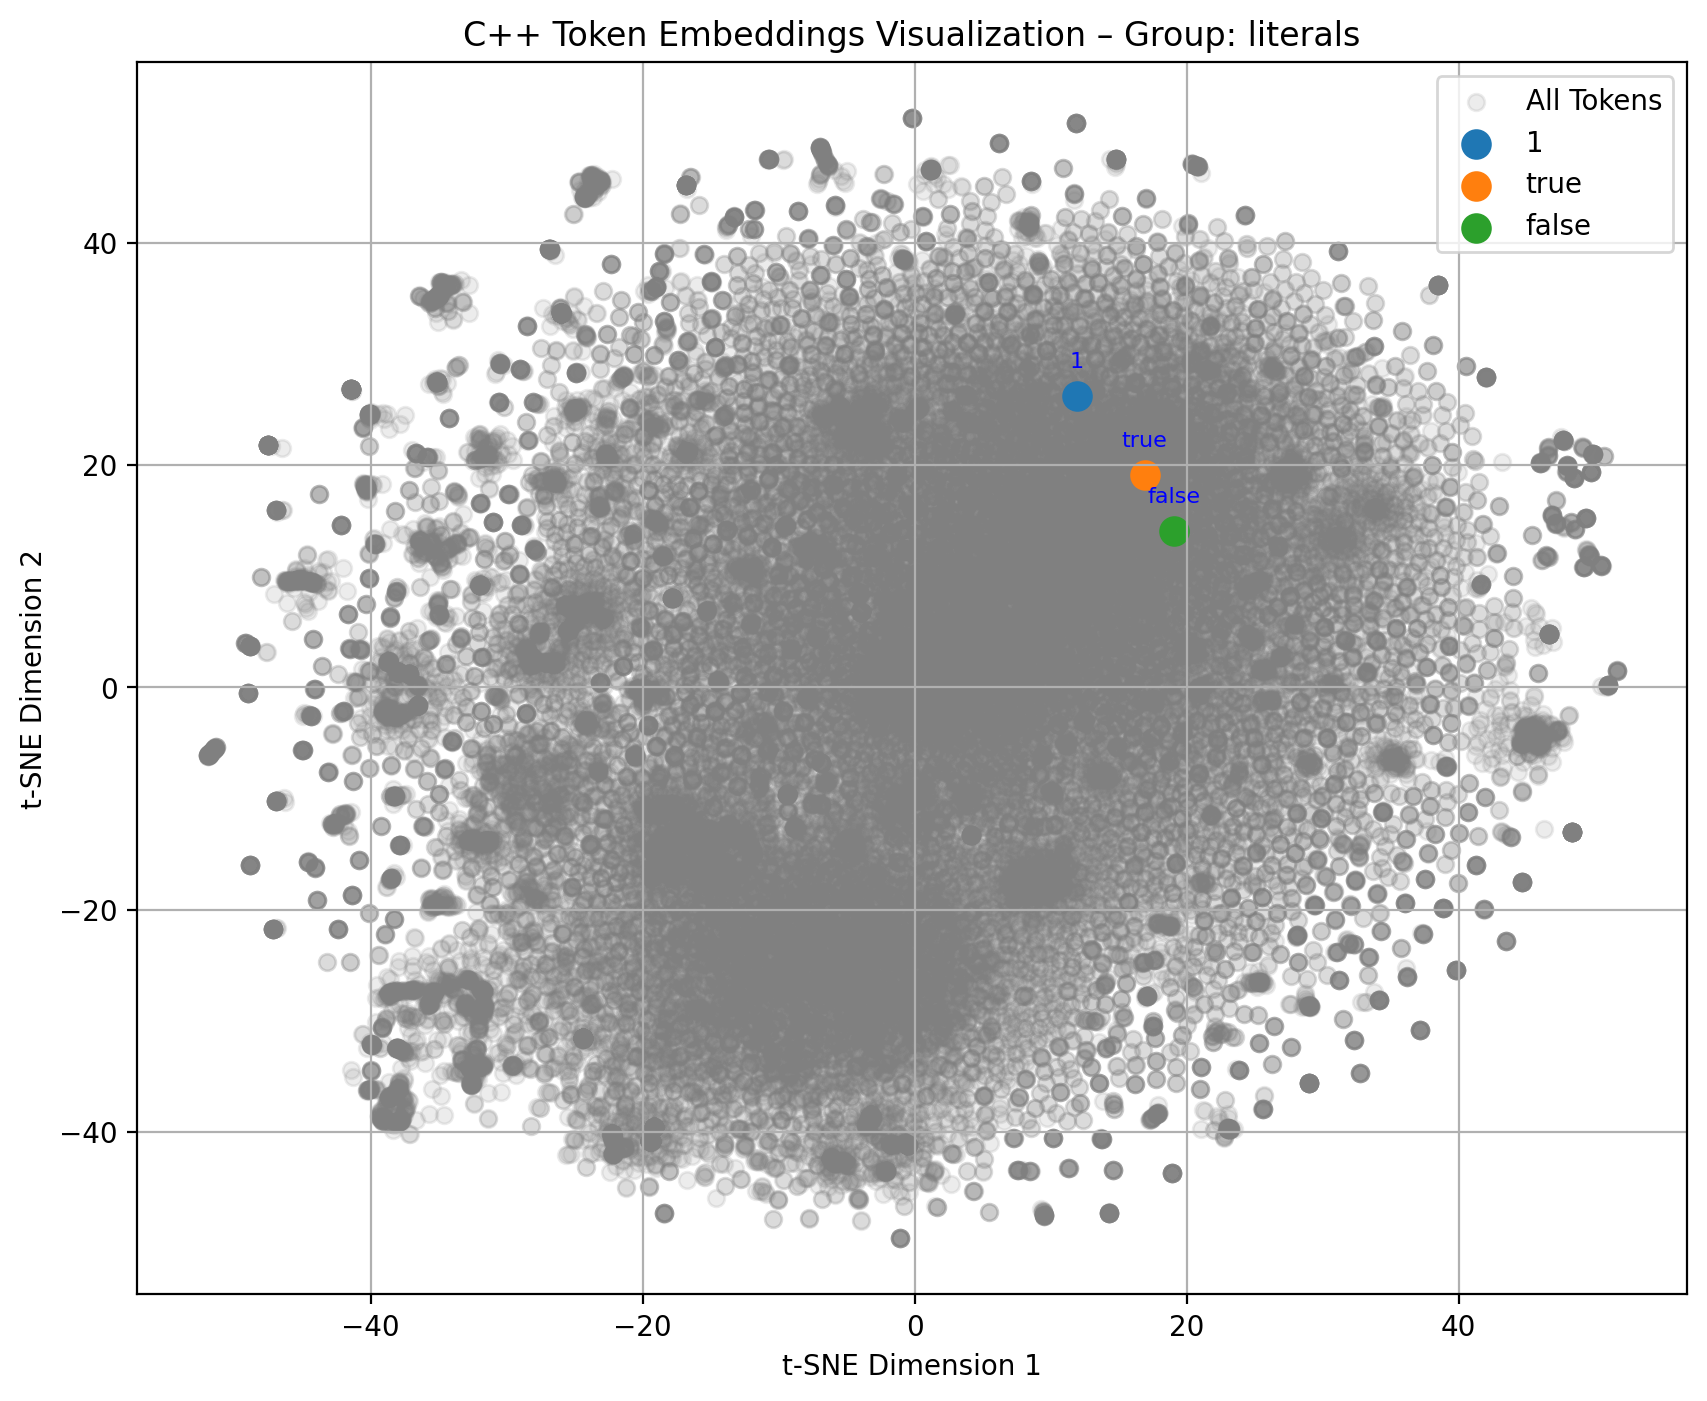

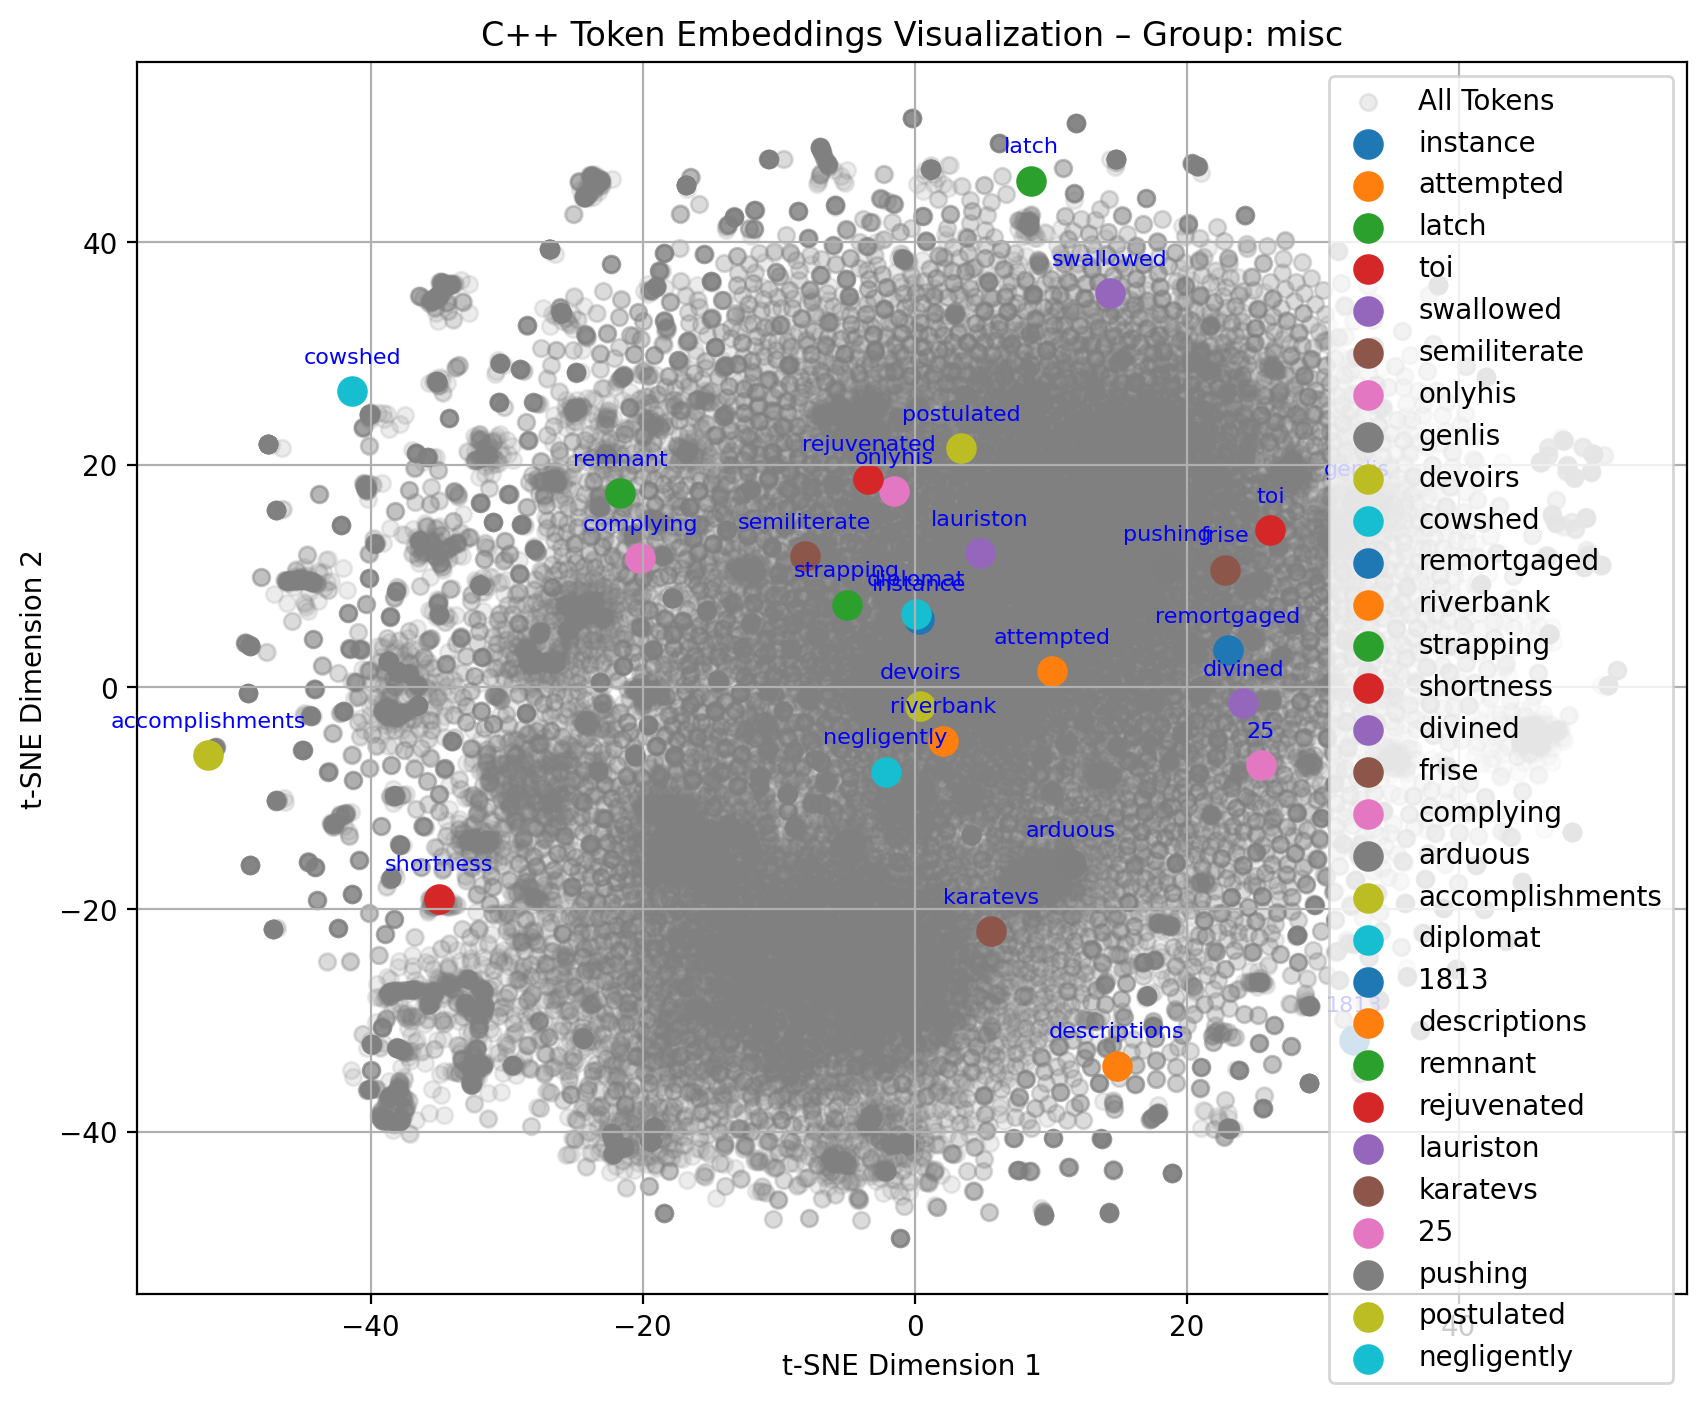

In [21]:
# ============================================================
# 1️⃣ Imports
# ============================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
import pickle

# ------------------------------------------------------
# 2️⃣ Device setup
# ------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------------------------------
# 3️⃣ Define the model class (same as training)
# ------------------------------------------------------
class NextTokenPredictor(torch.nn.Module):
    def __init__(self, vocab_size, context_size, embed_dim=64, hidden_dim=256):
        super().__init__()
        self.embed = torch.nn.Embedding(vocab_size, embed_dim)
        self.fc1 = torch.nn.Linear(context_size * embed_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, vocab_size)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.embed(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x


# ------------------------------------------------------
# 4️⃣ Load vocab dictionaries
# ------------------------------------------------------
with open("stoi1.pkl", "rb") as f:
    stoi = pickle.load(f)
with open("itos1.pkl", "rb") as f:
    itos = pickle.load(f)

vocab_size = len(stoi)
context_size = 5

# ------------------------------------------------------
# 5️⃣ Safe model load for PyTorch ≥ 2.6
# ------------------------------------------------------
import torch.serialization
torch.serialization.add_safe_globals([NextTokenPredictor])

# Load the entire model directly (no state_dict)
model = torch.load("cpp_next_token_model3.pt", map_location=device, weights_only=False)
model.to(device)
model.eval()

print("✅ Model loaded successfully!")
print("Embedding size:", model.embed.weight.shape)

# ------------------------------------------------------
# 6️⃣ Extract embeddings
# ------------------------------------------------------
embedding_weights = model.embed.weight.data.cpu().numpy()
print("Embedding matrix shape:", embedding_weights.shape)

# ------------------------------------------------------
# 7️⃣ Define C++ token groups for visualization
# ------------------------------------------------------
def group_cpp_tokens(itos, stoi):
    groups = {
        "keywords": ["if", "else", "for", "while", "return", "switch", "case", "break", "continue"],
        "datatypes": ["int", "float", "double", "char", "bool", "void", "string"],
        "operators": ["+", "-", "*", "/", "=", "==", "&&", "||", "<", ">", "<=", ">="],
        "punctuation": ["{", "}", "(", ")", ";", ",", "[", "]"],
        "literals": ["0", "1", "true", "false", "NULL"],
        "misc": []
    }

    # Keep only tokens that exist in vocab
    for k, v in groups.items():
        groups[k] = [tok for tok in v if tok in stoi]

    # Randomly sample remaining tokens for misc
    remaining = [t for t in itos.values() if t not in sum(groups.values(), [])]
    if remaining:
        groups["misc"] = random.sample(remaining, min(30, len(remaining)))
    return groups

groups = group_cpp_tokens(itos, stoi)

# ------------------------------------------------------
# 8️⃣ Compute t-SNE
# ------------------------------------------------------
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
embeddings_tsne = tsne.fit_transform(embedding_weights)

# Map token → 2D coordinate
token_to_coord = {itos[i]: embeddings_tsne[i] for i in range(len(itos))}

# ------------------------------------------------------
# 9️⃣ Visualize embeddings for each semantic group
# ------------------------------------------------------
for group_name, tokens in groups.items():
    if not tokens:
        continue

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1],
                alpha=0.15, label="All Tokens", color="gray")

    for tok in tokens:
        if tok in token_to_coord:
            x, y = token_to_coord[tok]
            plt.scatter(x, y, s=100, label=tok)
            plt.annotate(tok, (x, y),
                         textcoords="offset points", xytext=(0, 10),
                         ha='center', fontsize=8, color='blue')

    plt.title(f"C++ Token Embeddings Visualization – Group: {group_name}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.show()